# Steady-state Ligand-Receptor inference

`liana` provides different statistical methods to infer `ligand-receptor` interactions from single-cell transcriptomics data omics data using prior knowledge.
In this notebook we showcase how to use liana in its most basic form with toy data.

CAPIRE QUALI SONO QUALI COPPIE DI LIGANDI RECETTORI CHE COMPAIONO DOPO LIANA E NON COMPAIONO IN SCSEQCOMM R
fai lo unique di ligand&receptor
non dovremmo averli, perchè non sono presenti nel dataset

## Loading Packages

In [1]:
# import liana
import liana as li
# needed for visualization and toy data
import scanpy as sc

## Loading toy data

In the most general case, `liana`'s ligand-receptor methods use `anndata` objects with processed single-cell transcriptomics data, with pre-defined cell labels (identities), to infer ligand-receptor interactions among all pairs of cell identities.

To load the example data-set, simply run:

In [23]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
adata = sc.datasets.pbmc68k_reduced()
print(type(adata))
print(adata)
print(adata.obs["bulk_labels"].unique())
print(adata.var.head(5))
print(adata.X.shape)

import numpy as np
print(adata.var.head(1))


<class 'anndata._core.anndata.AnnData'>
AnnData object with n_obs × n_vars = 700 × 765
    obs: 'bulk_labels', 'n_genes', 'percent_mito', 'n_counts', 'S_score', 'G2M_score', 'phase', 'louvain'
    var: 'n_counts', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'bulk_labels_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'
['CD14+ Monocyte', 'Dendritic', 'CD56+ NK', 'CD4+/CD25 T Reg', 'CD19+ B', 'CD8+ Cytotoxic T', 'CD4+/CD45RO+ Memory', 'CD8+/CD45RA+ Naive Cytotoxic', 'CD4+/CD45RA+/CD25- Naive T', 'CD34+']
Categories (10, object): ['CD4+/CD25 T Reg', 'CD4+/CD45RA+/CD25- Naive T', 'CD4+/CD45RO+ Memory', 'CD8+ Cytotoxic T', ..., 'CD19+ B', 'CD34+', 'CD56+ NK', 'Dendritic']
            n_counts     means  dispersions  dispersions_norm  highly_variable
index                                                                         
HES4     1153.387451  0.59

The example single-cell data consists processed data with PBMCs cell types

/home/bio/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


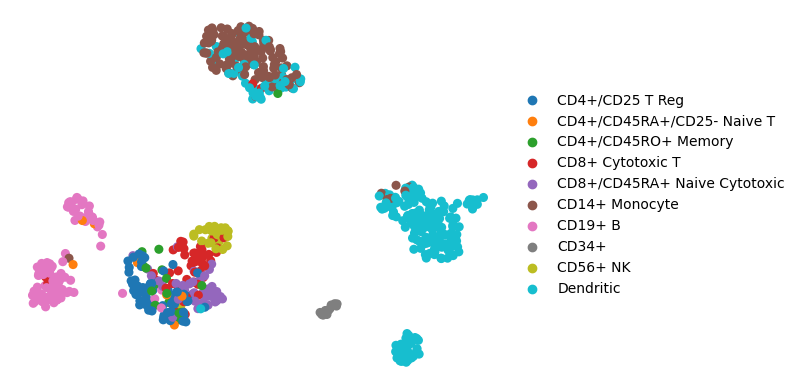

In [3]:
sc.pl.umap(adata, color='bulk_labels', title='', frameon=False)

## Background

`liana` typically works with the log1p-trasformed counts matrix, in this object the normalized counts are stored in `raw`:

In [1]:
print(adata.raw.X)
print(adata.X)


NameError: name 'adata' is not defined

Preferably, one would use `liana` with all features (genes) for which we have enough counts, but for the sake of this tutorial we are working with a matrix pre-filtered to the variable features alone.

In the background, `liana` aggregates the counts matrix and generates statistics, typically related to cell identies.
These statistics are then utilized by each of the methods in `liana`.

### Methods

In [5]:
li.mt.show_methods()

,Method Name,Magnitude Score,Specificity Score,Reference
0,CellPhoneDB,lr_means,cellphone_pvals,"Efremova, M., Vento-Tormo, M., Teichmann, S.A...."
0,Connectome,expr_prod,scaled_weight,"Raredon, M.S.B., Yang, J., Garritano, J., Wang..."
0,log2FC,None,lr_logfc,"Dimitrov, D., Türei, D., Garrido-Rodriguez, M...."
0,NATMI,expr_prod,spec_weight,"Hou, R., Denisenko, E., Ong, H.T., Ramilowski,..."
0,SingleCellSignalR,lrscore,None,"Cabello-Aguilar, S., Alame, M., Kon-Sun-Tack, ..."
0,CellChat,lr_probs,cellchat_pvals,"Jin, S., Guerrero-Juarez, C.F., Zhang, L., Cha..."
0,scSeqComm,inter_score,None,"Baruzzo, G., Cesaro, G., Di Camillo, B. 2022. ..."
0,Rank_Aggregate,magnitude_rank,specificity_rank,"Dimitrov, D., Türei, D., Garrido-Rodriguez, M...."
0,Geometric Mean,lr_gmeans,gmean_pvals,CellPhoneDBv2's permutation approach applied t...


Each method infers relevant ligand-receptor interactions relying on different assumptions and each method returns different ligand-receptor scores, typically a pair per method. One score corresponding to
the `magnitude` (strength) of interaction and the other reflecting how `specificity` of a given interaction to a pair cell identities.

<div class="alert alert-info">

**Note**
    
<h4> Method Class</h4>
    
Methods in liana are **callable** instances of the `Method` class. To obtain further information for each method the user can refer to the methods documentation `?method_name` or `?method.__call__`. Alternatively, users can use the `method.describe` function to get a short summary for each method.

</div>  


For example, if the user wishes to learn more about liana's `rank_aggregate` implementation, where we combine the scores of multiple methods, they could do the following: 

In [6]:
# import liana's rank_aggregate
from liana.mt import rank_aggregate

In [10]:
?rank_aggregate.__call__

Object `rank_aggregate.__call__` not found.


or alternatively:

In [8]:
rank_aggregate.describe()

Rank_Aggregate returns `magnitude_rank`, `specificity_rank`. magnitude_rank and specificity_rank respectively represent an aggregate of the `magnitude`- and `specificity`-related scoring functions from the different methods.


#### Resources

To provide ligand-receptor predictions `liana` relies on prior-knowledge and makes use of the following ligand-receptor resources:

In [6]:
li.resource.show_resources()

['baccin2019',
 'cellcall',
 'cellchatdb',
 'cellinker',
 'cellphonedb',
 'celltalkdb',
 'connectomedb2020',
 'consensus',
 'embrace',
 'guide2pharma',
 'hpmr',
 'icellnet',
 'italk',
 'kirouac2010',
 'lrdb',
 'mouseconsensus',
 'ramilowski2015']

These were pre-generated using the [OmniPath](https://github.com/saezlab/omnipath) meta-database, but any custom resource can also be passed.
We refer the user to [OmniPath](https://github.com/saezlab/omnipath) as a useful tool to build any resource.

    
By default, `liana` uses the `consensus` resource, which is composed by multiple expert-curated ligand-receptor resources, including CellPhoneDB, CellChat, ICELLNET, connectomeDB2020, and CellTalkDB.


## Example Run

### Individual Methods

In [25]:
# import all individual methods
from liana.method import singlecellsignalr, connectome, cellphonedb, natmi, logfc, cellchat, geometric_mean, scseqcomm

HES4

<div class="alert alert-info">

**Note**

LIANA will by default use the `.raw` attribute of AnnData. If you wish to use .X set `use_raw` to `False`, or specify a `layer`.
    
    
</div>  

In [27]:
# run cellphonedb
#cellphonedb(adata, groupby='bulk_labels', expr_prop=0.1, verbose=True, key_added='cpdb_res')

singlecellsignalr(adata, groupby='bulk_labels', verbose=True, key_added='scs_res')

# run scseqcomm
#scseqcomm(adata, groupby='bulk_labels', verbose=True, key_added='scseqcomm_res')

Using `.raw`!
Using resource `consensus`.
0.94 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 700 samples and 765 features


In [29]:
adata.uns['scs_res']

,ligand,ligand_complex,ligand_means,ligand_props,mat_mean,receptor,receptor_complex,receptor_means,receptor_props,source,target,lrscore
1205,TIMP1,TIMP1,2.323713,0.922481,0.595788,CD63,CD63,1.945774,0.838710,CD14+ Monocyte,CD56+ NK,0.781134
1200,S100A9,S100A9,1.873930,0.798450,0.595788,ITGB2,ITGB2,2.240322,0.967742,CD14+ Monocyte,CD56+ NK,0.774727
929,S100A9,S100A9,1.873930,0.798450,0.595788,ITGB2,ITGB2,2.091551,0.945736,CD14+ Monocyte,CD14+ Monocyte,0.768675
1221,SPON2,SPON2,1.656323,0.709677,0.595788,ITGB2,ITGB2,2.240322,0.967742,CD56+ NK,CD56+ NK,0.763774
983,SPON2,SPON2,1.656323,0.709677,0.595788,ITGB2,ITGB2,2.091551,0.945736,CD56+ NK,CD14+ Monocyte,0.757519
1334,S100A9,S100A9,1.873930,0.798450,0.595788,ITGB2,ITGB2,1.771745,0.900000,CD14+ Monocyte,Dendritic,0.753594
1235,TIMP1,TIMP1,1.637212,0.791667,0.595788,CD63,CD63,1.945774,0.838710,Dendritic,CD56+ NK,0.749735
1339,TIMP1,TIMP1,2.323713,0.922481,0.595788,CD63,CD63,1.286075,0.695833,CD14+ Monocyte,Dendritic,0.743693
1230,S100A9,S100A9,1.320579,0.583333,0.595788,ITGB2,ITGB2,2.240322,0.967742,Dendritic,CD56+ NK,0.742732
1386,SPON2,SPON2,1.656323,0.709677,0.595788,ITGB2,ITGB2,1.771745,0.900000,CD56+ NK,Dendritic,0.741955


By default, liana will be run **inplace** and results will be assigned to `adata.uns['liana_res']`.
Note that the high proportion of missing entities here is expected, as we are working on the reduced dimensions data.

In [9]:
# by default, liana's output is saved in place:
print(adata)
#adata.uns['cpdb_res'].head()
adata.uns['scseqcomm_res'].head()

AnnData object with n_obs × n_vars = 700 × 765
    obs: 'bulk_labels', 'n_genes', 'percent_mito', 'n_counts', 'S_score', 'G2M_score', 'phase', 'louvain'
    var: 'n_counts', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'bulk_labels_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups', 'scseqcomm_res'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'


,ligand,ligand_complex,ligand_means,ligand_props,ligand_score,receptor,receptor_complex,receptor_means,receptor_props,receptor_score,source,target,inter_score
1334,S100A9,S100A9,1.873930,0.798450,1.0,ITGB2,ITGB2,1.771745,0.900000,1.0,CD14+ Monocyte,Dendritic,1.0
1412,TIMP1,TIMP1,1.637212,0.791667,1.0,CD63,CD63,1.286075,0.695833,1.0,Dendritic,Dendritic,1.0
929,S100A9,S100A9,1.873930,0.798450,1.0,ITGB2,ITGB2,2.091551,0.945736,1.0,CD14+ Monocyte,CD14+ Monocyte,1.0
1407,S100A9,S100A9,1.320579,0.583333,1.0,ITGB2,ITGB2,1.771745,0.900000,1.0,Dendritic,Dendritic,1.0
1004,S100A9,S100A9,1.320579,0.583333,1.0,ITGB2,ITGB2,2.091551,0.945736,1.0,Dendritic,CD14+ Monocyte,1.0


Here, we see that stats are provided for both ligand and receptor entities, more specifically: `ligand` and `receptor` are the two entities that potentially interact. As a reminder, CCC events are not limited to secreted signalling, but we refer to them as `ligand` and `receptor` for simplicity.

Also, in the case of heteromeric complexes, the `ligand` and `receptor` columns represent the subunit with minimum expression, while `*_complex` corresponds to the actual complex, with subunits being separated by `_`.

- `source` and `target` columns represent the source/sender and target/receiver cell identity for each interaction, respectively

- `*_props`: represents the proportion of cells that express the entity. 

  By default, any interactions in which either entity is not expressed in above 10% of cells per cell type is considered as a false positive,
  under the assumption that since CCC occurs between cell types, a sufficient proportion of cells within should express the genes.

- `*_means`: entity expression mean per cell type

- `lr_means`: mean ligand-receptor expression, as a measure of ligand-receptor interaction **magnitude**

- `cellphone_pvals`: permutation-based p-values, as a measure of interaction **specificity**

<div class="alert alert-info">

**Note**
    
`ligand`, `receptor`, `source`, and `target` columns are returned by every ligand-receptor method, while the rest of the columns can vary across the ligand-receptor methods, as each method infers relies on different assumptions and scoring functions, and hence each returns different ligand-receptor scores. Nevertheless, typically most methods use a pair of scoring functions - where one often corresponds to the **magnitude** (strength) of interaction and the other reflects how **specificity** of a given interaction to a pair cell identities.
    
</div>

#### Dotplot

We can now visualize the results that we just obtained.

LIANA provides some basic, but flexible plotting functionalities. Here, we will generate a dotplot of relevant ligand-receptor interactions.

Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


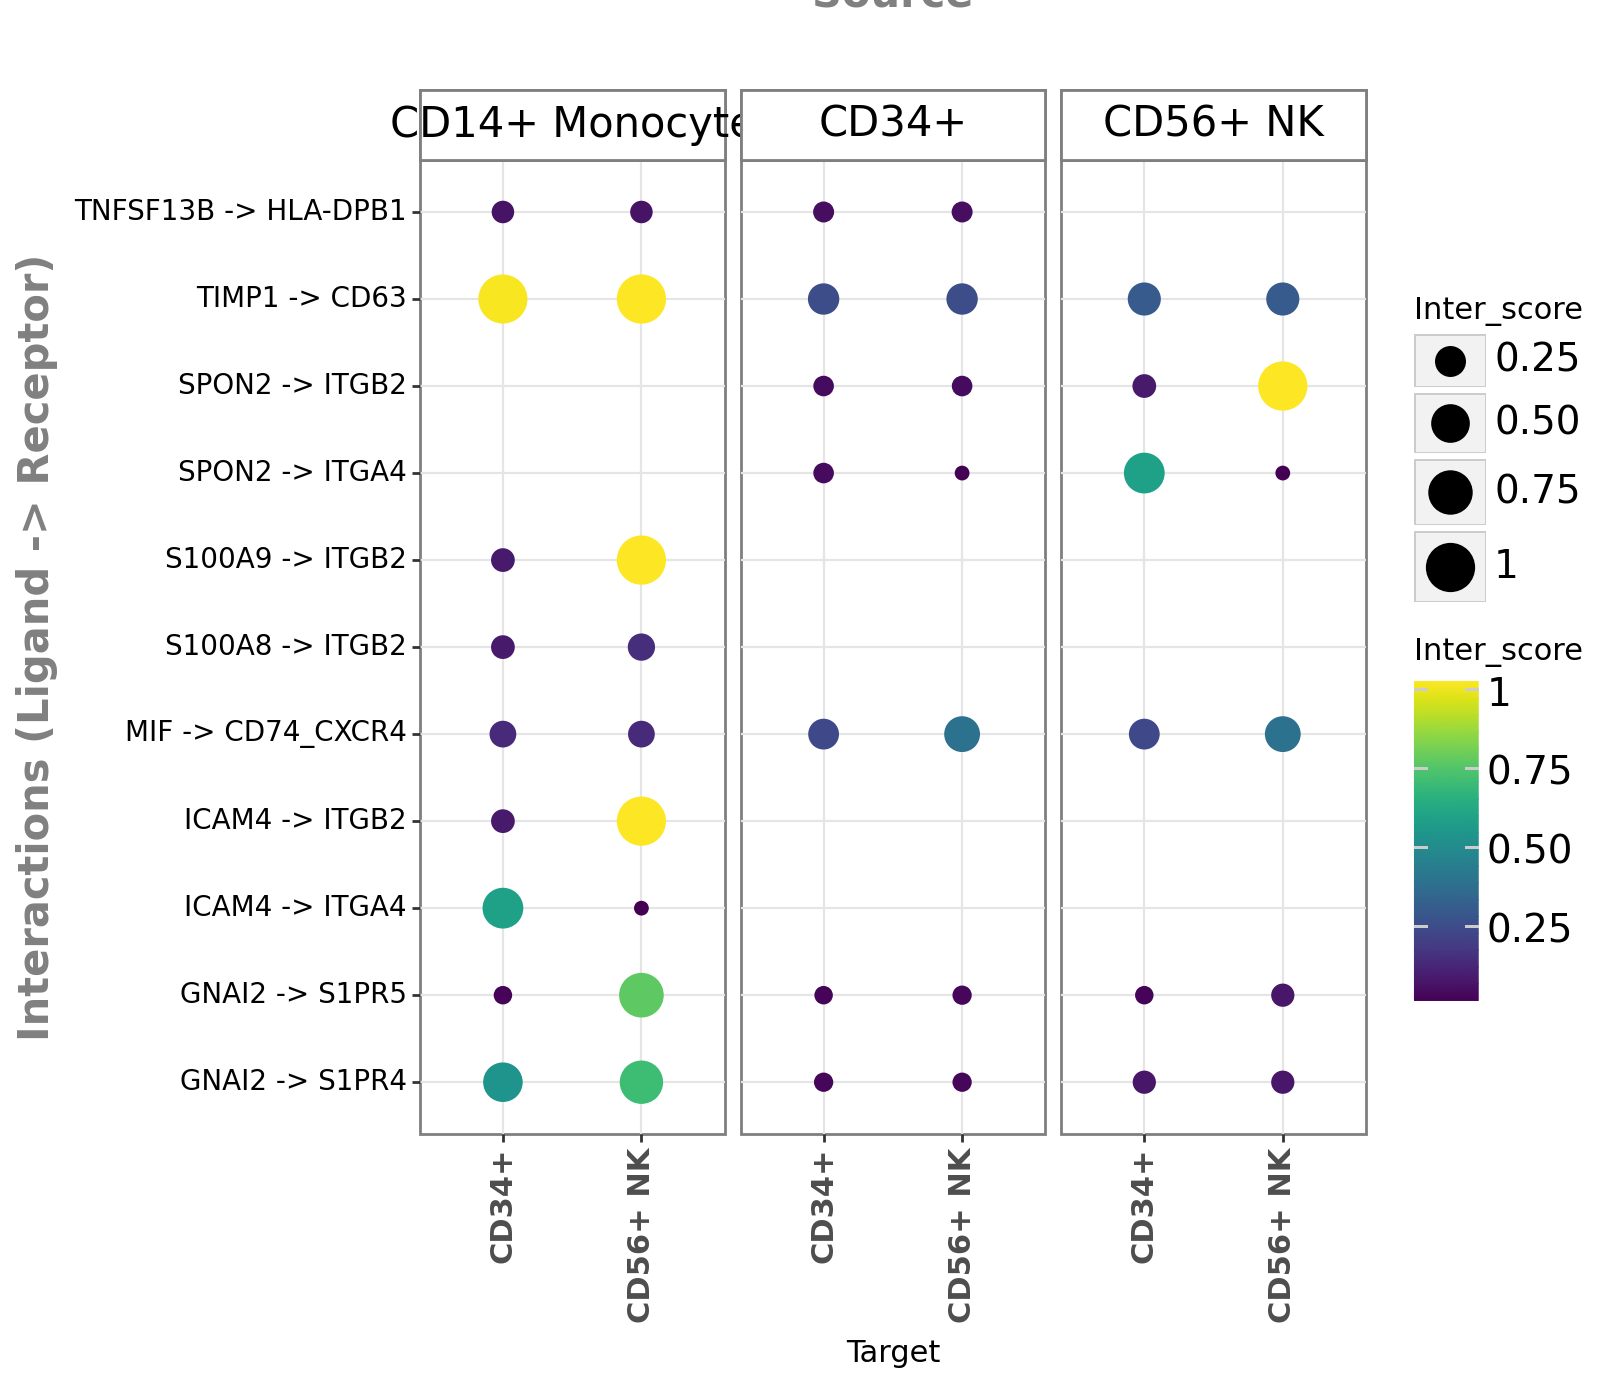

<Figure Size: (800 x 700)>

In [10]:
"""
li.pl.dotplot(adata = adata, 
              colour='lr_means',
              size='cellphone_pvals',
              inverse_size=True, # we inverse sign since we want small p-values to have large sizes
              source_labels=['CD34+', 'CD56+ NK', 'CD14+ Monocyte'],
              target_labels=['CD34+', 'CD56+ NK'],
              figure_size=(8, 7),
              # finally, since cpdbv2 suggests using a filter to FPs
              # we filter the pvals column to <= 0.05
              filterby='cellphone_pvals',
              filter_lambda=lambda x: x <= 0.05,
              uns_key='cpdb_res' # uns_key to use, default is 'liana_res' 
             )
"""
li.pl.dotplot(adata = adata, 
              colour='inter_score',
              size='inter_score',
              inverse_size=False, # we inverse sign since we want small p-values to have large sizes
              source_labels=['CD34+', 'CD56+ NK', 'CD14+ Monocyte'],
              target_labels=['CD34+', 'CD56+ NK'],
              figure_size=(8, 7),
              # finally, since cpdbv2 suggests using a filter to FPs
              # we filter the pvals column to <= 0.05
              #filterby='cellphone_pvals',
              #filter_lambda=lambda x: x <= 0.05,
              uns_key='scseqcomm_res' # uns_key to use, default is 'liana_res' 
             )

<div class="alert alert-info">
   
**Note**
    
Missing dots here would represent interactions for which the ligand and receptor are not expressed above the `expr_prop`. One can change this threshold by setting `expr_prop` to a different value. Alternatively, setting `return_all_lrs` to `True` will return all ligand-receptor interactions, regardless of expression.
</div>

#### Tileplot

While dotplots are useful to visualize the most relevant interactions, LIANA's tileplots are more useful when visualizing the statistics of ligands and receptors, individually.

/home/bio/projects/LIANA2-scSeqCOMM/liana-py/liana/plotting/_common.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


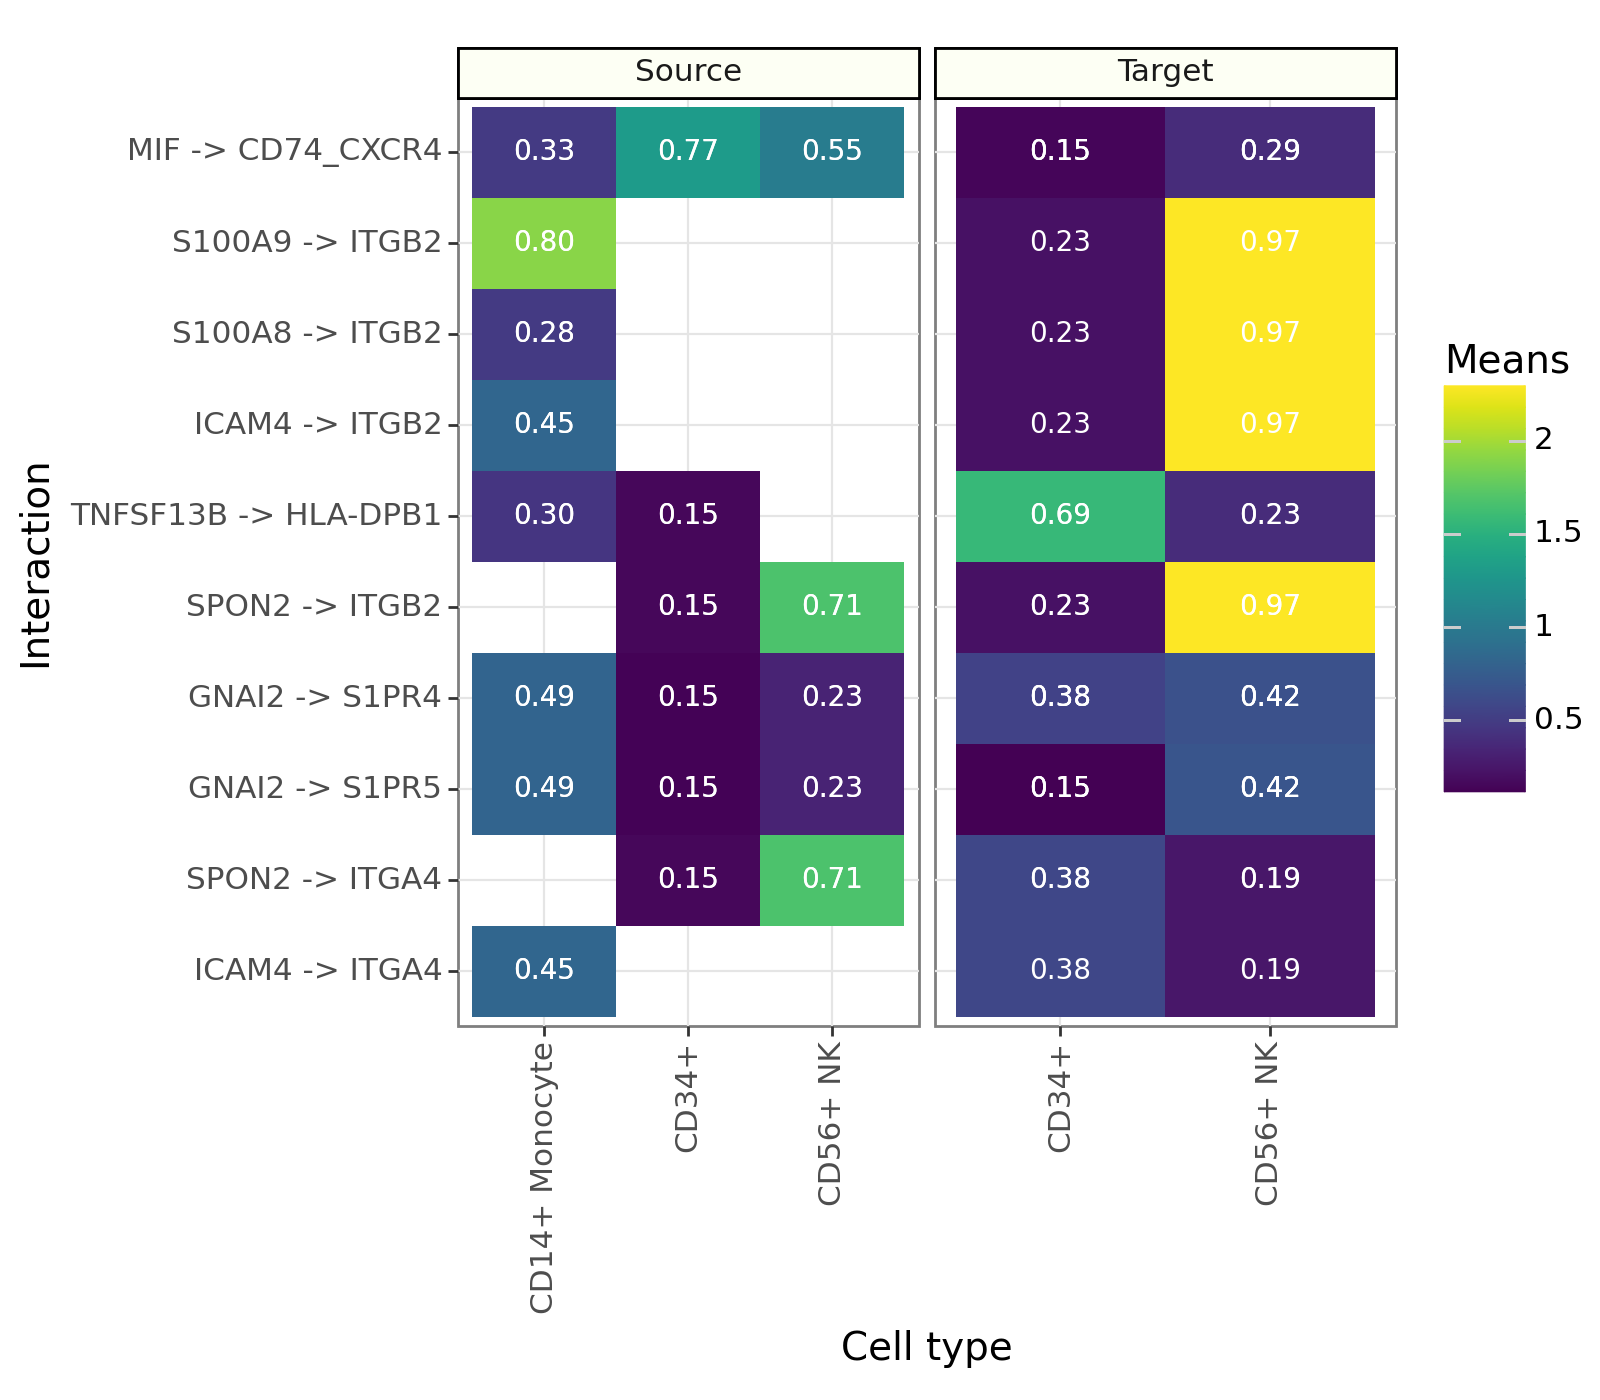

<Figure Size: (800 x 700)>

In [12]:
""" 
my_plot = li.pl.tileplot(adata = adata, 
                         # NOTE: fill & label need to exist for both
                         # ligand_ and receptor_ columns
                         fill='means',
                         label='props',
                         label_fun=lambda x: f'{x:.2f}',
                         top_n=10, 
                         orderby='cellphone_pvals',
                         orderby_ascending=True,
                         source_labels=['CD34+', 'CD56+ NK', 'CD14+ Monocyte'],
                         target_labels=['CD34+', 'CD56+ NK'],
                         uns_key='cpdb_res' # NOTE: default is 'liana_res'
                         ) 
"""
my_plot = li.pl.tileplot(adata = adata, 
                         # NOTE: fill & label need to exist for both
                         # ligand_ and receptor_ columns
                         fill='means',
                         label='props',
                         label_fun=lambda x: f'{x:.2f}',
                         top_n=10, 
                         orderby='inter_score',
                         orderby_ascending=True,
                         source_labels=['CD34+', 'CD56+ NK', 'CD14+ Monocyte'],
                         target_labels=['CD34+', 'CD56+ NK'],
                         figure_size=(8, 7),
                         uns_key='scseqcomm_res' # NOTE: default is 'liana_res'
                         ) 
my_plot

### Rank Aggregate
In addition to the individual methods, LIANA also provides a consensus that integrates the predictions of individual methods.
This is done by ranking and aggregating ([RRA](https://academic.oup.com/bioinformatics/article-abstract/28/4/573/213339)) the ligand-receptor interaction predictions from all methods.

In [15]:
# Run rank_aggregate
li.mt.rank_aggregate(adata, groupby='bulk_labels', expr_prop=0.1, verbose=True)

Using `.raw`!
Using resource `consensus`.
0.94 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 700 samples and 765 features
Assuming that counts were `natural` log-normalized!
Running CellPhoneDB


100%|██████████| 1000/1000 [00:02<00:00, 341.86it/s]


Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR
Running CellChat


100%|██████████| 1000/1000 [00:03<00:00, 331.70it/s]


In [16]:
adata.uns['liana_res'].head()

,source,target,ligand_complex,receptor_complex,lr_means,cellphone_pvals,expr_prod,scaled_weight,lr_logfc,spec_weight,lrscore,lr_probs,cellchat_pvals,specificity_rank,magnitude_rank
1092,CD14+ Monocyte,CD56+ NK,TIMP1,CD63,2.134744,0.0,4.521421,0.966945,1.435273,0.060475,0.781134,0.205616,0.000,0.000185,0.000026
294,Dendritic,CD4+/CD45RA+/CD25- Naive T,HLA-DRA,CD4,2.566905,0.0,2.705027,0.709428,1.332656,0.063302,0.734081,0.104212,0.006,0.006370,0.000073
1088,CD14+ Monocyte,CD56+ NK,S100A9,ITGB2,2.057126,0.0,4.198207,0.834976,1.069681,0.095159,0.774727,0.185972,0.000,0.000185,0.000104
847,CD14+ Monocyte,CD14+ Monocyte,S100A9,ITGB2,1.982740,0.0,3.919420,0.757121,1.069747,0.088840,0.768675,0.176124,0.000,0.000185,0.000234
297,Dendritic,CD4+/CD45RA+/CD25- Naive T,HLA-DRB1,CD4,2.406652,0.0,2.513965,0.698344,1.232695,0.058561,0.726870,0.096314,0.008,0.006370,0.000246


In [17]:
rank_aggregate.describe()

Rank_Aggregate returns `magnitude_rank`, `specificity_rank`. magnitude_rank and specificity_rank respectively represent an aggregate of the `magnitude`- and `specificity`-related scoring functions from the different methods.


The remainder of the columns in this dataframe are those coming from each of the methods included in the `rank_aggregate` - i.e. see the `show_methods` to map methods to scores.

#### Dotplot

We will now plot the most 'relevant' interactions ordered to the `magnitude_rank` results from aggregated_rank.

/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/liana/plotting/_common.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


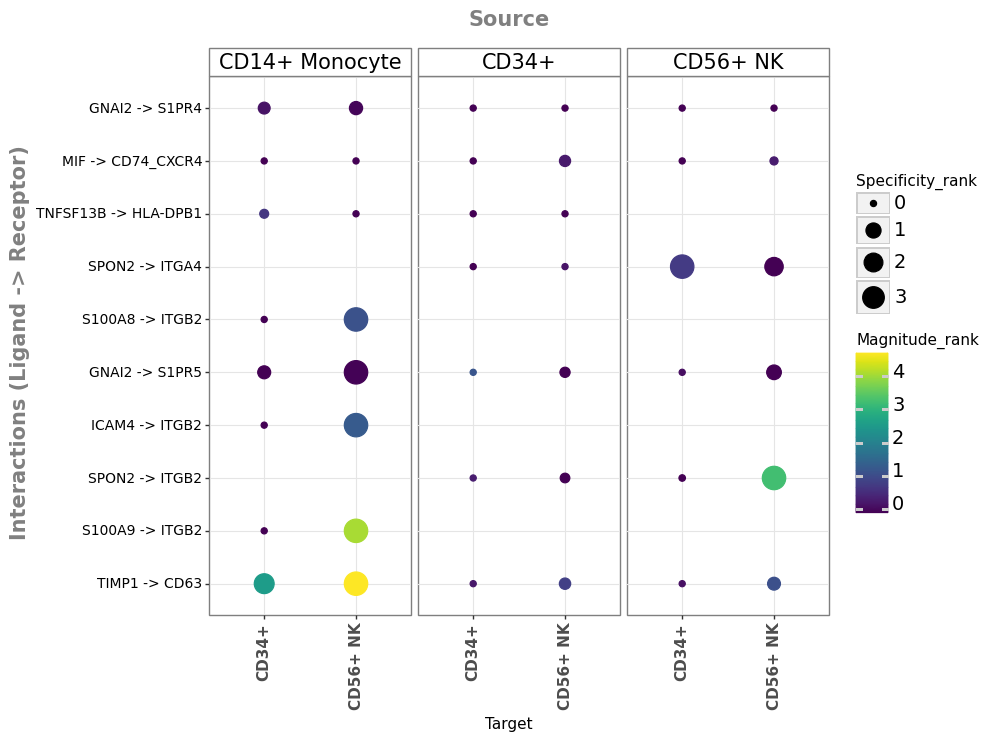

<ggplot: (8728342514523)>

In [18]:
li.pl.dotplot(adata = adata, 
              colour='magnitude_rank',
              size='specificity_rank',
              inverse_size=True,
              inverse_colour=True,
              source_labels=['CD34+', 'CD56+ NK', 'CD14+ Monocyte'],
              target_labels=['CD34+', 'CD56+ NK'],
              top_n=10, 
              orderby='magnitude_rank',
              orderby_ascending=True,
              figure_size=(8, 7)
             )

Similarly, we can also treat the ranks provided by RRA as a probability distribution to which we can `filter` interactions
according to how robustly and highly ranked they are across the different methods.

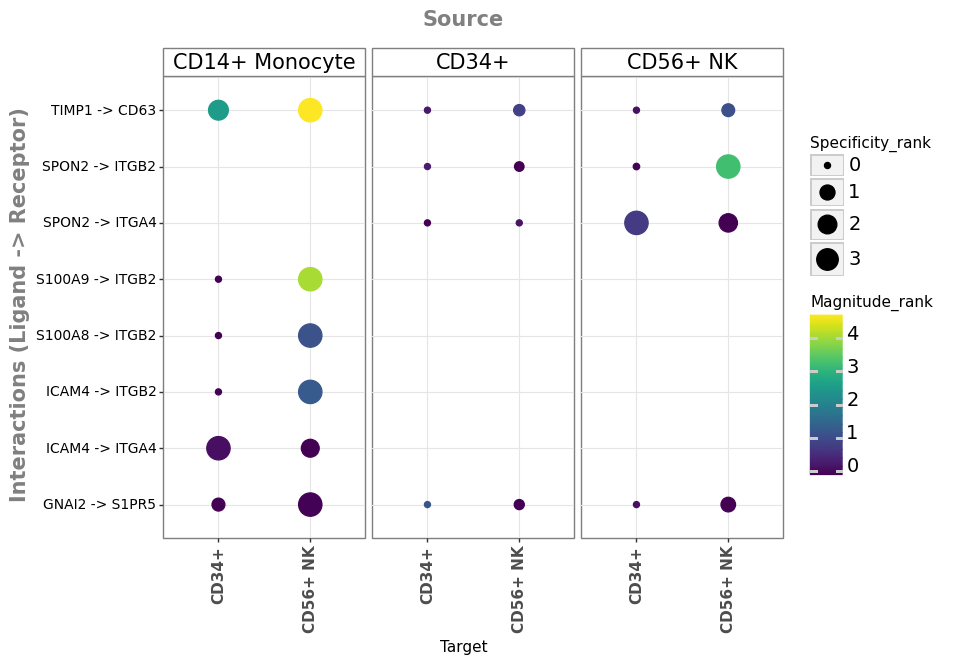

<ggplot: (8728337116094)>

In [19]:
my_plot = li.pl.dotplot(adata = adata, 
                        colour='magnitude_rank',
                        inverse_colour=True,
                        size='specificity_rank',
                        inverse_size=True,
                        source_labels=['CD34+', 'CD56+ NK', 'CD14+ Monocyte'],
                        target_labels=['CD34+', 'CD56+ NK'],
                        filterby='specificity_rank',
                        filter_lambda=lambda x: x <= 0.01,
                       )
my_plot

Save the plot to a file:

In [20]:
my_plot.save('dotplot.pdf')

/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 8 x 6 in image.
/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: dotplot.pdf


#### Customizing LIANA's Plots

Finally, the plots in liana are built with `plotnine` and their aesthetics can be easily modified. For example:

In [21]:
# we import plotnine
import plotnine as p9

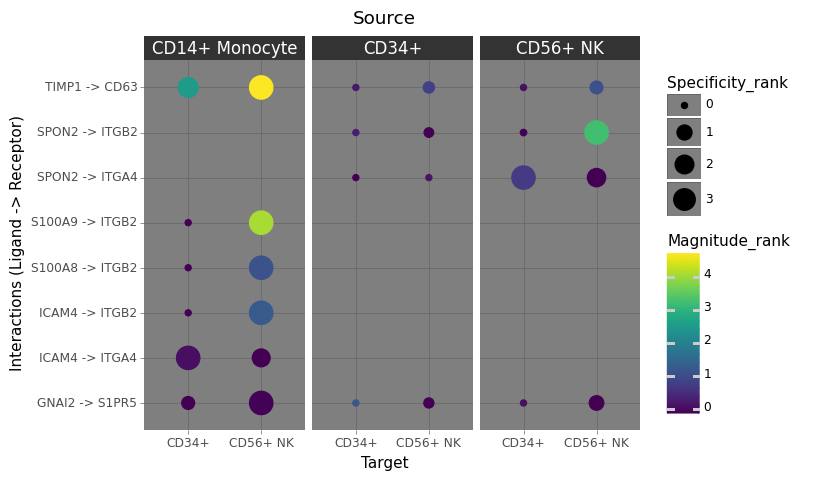

<ggplot: (8728336893652)>

In [22]:
(my_plot +
 # change theme
 p9.theme_dark() +
 # modify theme
 p9.theme(
     # adjust facet size
     strip_text=p9.element_text(size=12)
 )
)

For more plot modification options  we refer the user to `plotnine`'s tutorials
and to the following link for a quick intro: 
https://datacarpentry.org/python-ecology-lesson/07-visualization-ggplot-python/index.html.

## Customizing LIANA's rank aggregate

LIANA's rank aggregate is also customizable, and the user can choose to include only a subset of the methods.

For example, let's generate a consensus with geometric mean and logfc methods only:

In [23]:
methods = [logfc, geometric_mean]
new_rank_aggregate = li.mt.AggregateClass(li.mt.aggregate_meta, methods=methods)

In [24]:
new_rank_aggregate(adata,
                   groupby='bulk_labels',
                   expr_prop=0.1, 
                   verbose=True,
                   # Note that with this option, we don't perform permutations
                   # and hence we exclude the p-value for geometric_mean, as well as specificity_rank
                   n_perms=None,
                   use_raw=True,
                   )

Using `.raw`!
Using resource `consensus`.
0.94 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 700 samples and 765 features
Assuming that counts were `natural` log-normalized!
Running log2FC
Running Geometric Mean


Check the results

In [25]:
adata.uns['liana_res'].head()

,source,target,ligand_complex,receptor_complex,lr_logfc,lr_gmeans,magnitude_rank
1092,CD14+ Monocyte,CD56+ NK,TIMP1,CD63,1.435273,2.126363,0.000776
1088,CD14+ Monocyte,CD56+ NK,S100A9,ITGB2,1.069681,2.048953,0.001553
847,CD14+ Monocyte,CD14+ Monocyte,S100A9,ITGB2,1.069747,1.979752,0.002329
1106,CD56+ NK,CD56+ NK,SPON2,ITGB2,1.860055,1.926317,0.003106
898,CD56+ NK,CD14+ Monocyte,SPON2,ITGB2,1.860121,1.861258,0.003882
